# Suche
Bevor wir dem Computer beibringen, Probleme wie das Schiebepuzzle auf "intelligente" Weise zu lösen, schauen wir uns zuerst einen sogenannten "brute force"-Ansatz an, d.h. wir lösen das Problem "mit roher Gewalt", indem wir systematisch *alle* möglichen Zugfolgen ausprobieren und nach einem Zielzustand suchen.  Und das geht so:

Ausgehend vom Startzustand eines Puzzles bestimmen wir alle möglichen *Folgezustände*, d.h. diejenigen Zustände, die durch einen Zug erreicht werden können. Als nächstes betrachten wir *deren* Folgezustände, usw. Dadurch entsteht ein sogenannter **Suchbaum**. 

* Jeder *Knoten* des Baums entspricht einem Spielzustand
* Der *Wurzelknoten* (ganz oben) enthält den Startzustand des Puzzles
* Eine *Kante* von einem Knoten *x* zu einem Knoten *y* zeigt an, dass *y* ein Folgezustand von *x* ist, d.h. dass in *x* ein Zug möglich ist, der *x* in *y* überführt.
* Eine *Lösung* für das Puzzle ist also ein *Pfad* durch den Baum vom Wurzelknoten bis zu einem Knoten, der die gegebene *Zielbedingung* erfüllt (in unserem Fall: ein Puzzlezustand, der genau der Zielkonfiguration entspricht)

Die folgende Abbildung zeigt den Anfang eines solchen Suchbaums:

![images/breitensuche_suchbaum01.png](images/breitensuche_suchbaum01.png)
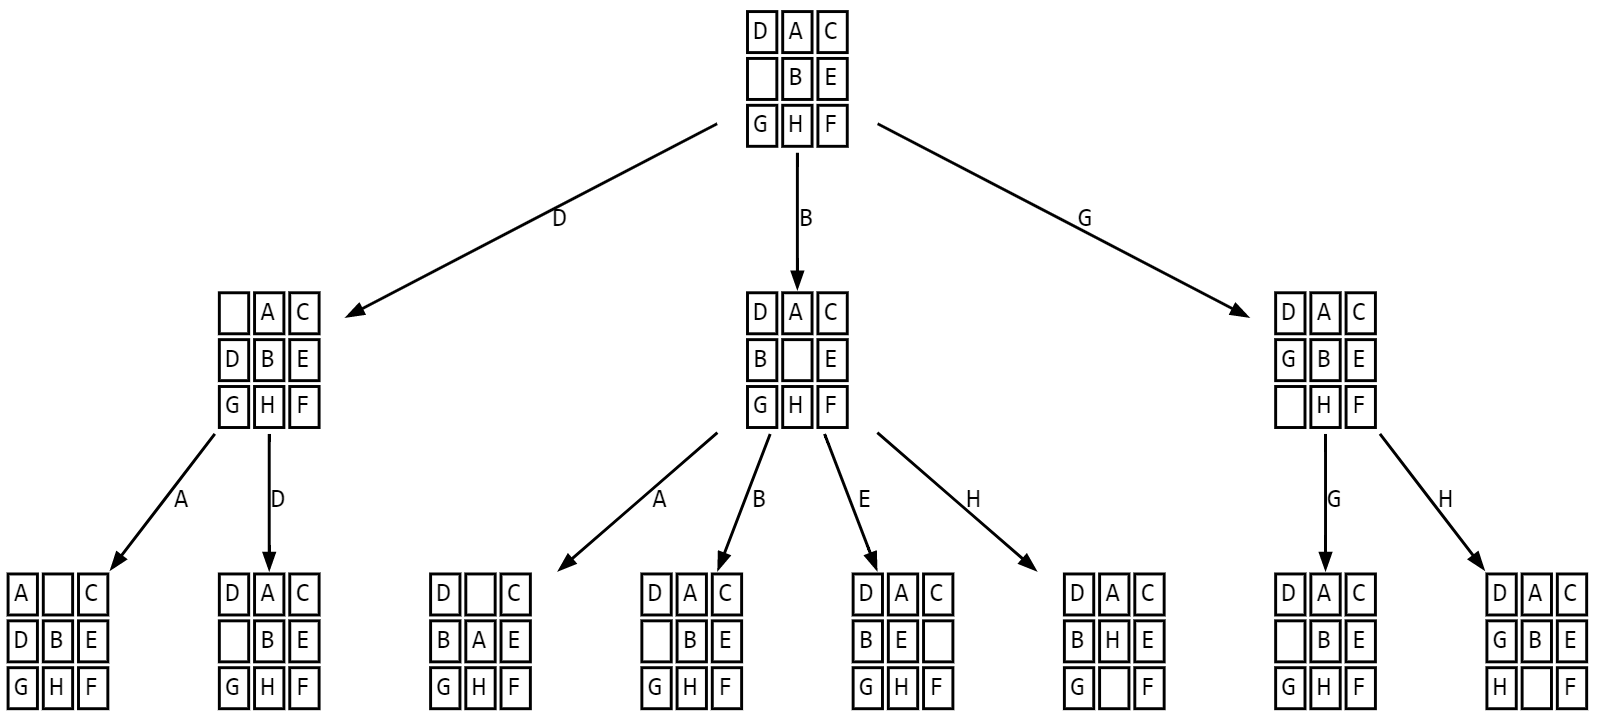

Viele Problemstellungen der KI lassen sich als Suchprobleme modellieren: z.V. das Lösen von Sudokus, die Routenplanung in einem Navigationsgerät oder die Aktionsplanung für einen autonomen Roboter. Allen diesen Problemstellungen gemein ist, dass

* es in jedem Zustand eine Reihe möglicher Aktionen (Züge) gibt
* die Ausführung eines Zugs in einem bestimmten Zustand in einen neuen Zustand führt
* bestimmte Zustände eine Zielbedingung erfüllen, d.h. dass das Problem gelöst ist, wenn man einen dieser Zustände erreicht hat
* die gesuchte Lösung nicht der Zielzustand selbst ist, sondern eine Aktionssequenz, die den Start- in den Zielzustand überführt

Gelingt es, eine Problemstellung als ein solches Suchproblem zu modellieren, kann man es mit einem (problemunabhängigen!) Suchalgorithmus lösen. Diesen Algorithmus muss man also nicht immer wieder neu programmieren, sondern kann ihn *nahezu unverändert* auf viele verschiedene Problemstellungen anwenden!

### Suchprobleme

Wir beschreiben die folgenden Algorithmen deshalb für eine generelle Klasse `Suchproblem`. Für konkrete Aufgaben (z.B. unser Schiebepuzzle) leiten wir von `Suchproblem` ab und implementieren die abstrakten Methoden, so dass die Suchalgorithmen automatisch dem jeweiligen Problem angepasst werden.

(Falls du dich schon einmal mit *Entwurfsmustern* beschäftigt hast: Dies ist das Muster ["Schablonenmethode", engl. "template method"](https://de.wikipedia.org/wiki/Schablonenmethode)).

In [1]:
class Suchproblem:
    """Abstrakte Klasse für allgemeine Suchprobleme 
    Konkrete Problemklassen werden von dieser Klasse abgeleitet und überschreiben die Methoden 
    moegliche_aktionen() und fuehre_aktion_aus(), evtl. auch ist_zielzustand(). 
    
    (Deklaration als abstrakte Klasse funktioniert in Python etwas anders 
    als in Java etc. Deshalb hier der Übersichtlichkeit wegen weggelassen.)"""

    def __init__(self, startzustand, zielzustand=None):
        """erzeugt ein neues Suchproblem mit festem Startzustand.
        Falls kein Zielzustand vorgegeben wird, muss die Methode ist_zielzustand() überschrieben werden."""
        
        self.startzustand = startzustand
        self.zielzustand = zielzustand

    def moegliche_aktionen(self, zustand):
        """liefert alle in zustand möglichen Aktionen zurück."""
        
        pass     # wird es von den konkreten Subklassen überschrieben.

    def fuehre_aktion_aus(self, zustand, aktion):
        """wendet aktion in zustand an und gibt den daraus resultierenden
        neuen Zustand zurück. """
        
        pass     # wird es von den konkreten Subklassen überschrieben.

    def ist_zielzustand(self, zustand):
        """prüft, ob der übergebene Zustand die Zielbedingung erfüllt.
        Standardverhalten: Es gibt genau einen Zielzustand self.ziel_zustand, mit dem zustand verglichen wird.
        Unterklassen von Suchproblem können diese Methode überschreiben und so andere Zieltests implementieren. """
        return zustand == self.zielzustand

Um Such-Algorithmen zur Lösung des Schiebepuzzles verwenden zu können, müssen wir das Schiebepuzzle als Subklasse von `Suchproblem` darstellen. Dabei müssen wir insb. beschreiben, was beim Schiebepuzzle `moegliche_aktionen()` sind und was `fuehre_aktion_aus()` konkret bedeutet. Zum Glück haben wir zwei passende Funktionen bereits in unserer ursprünglichen Implementation des Schiebepuzzles programmiert. Hier noch einmal zur Erinnerung:

In [2]:
# Die beiden folgenden Funktionen stammen aus schiebepuzzle.py, unserer "Bibliothek" für das Schiebepuzzle-Spiel

def moegliche_zuege(puzzle):
    leer_pos = puzzle.index(' ')
    y, x = divmod(leer_pos, 3)  # kurz für: y, x = leer_pos // 3, leer_pos % x
    kandidaten = [(x, y - 1), (x - 1, y), (x + 1, y), (x, y + 1)]
    nachbarn = [k for k in kandidaten if k[0] in [0, 1, 2] and k[1] in [0, 1, 2]]
    return [kx + 3 * ky for (kx, ky) in nachbarn]

def verschiebe_pos(puzzle, pos):
    leer_pos = puzzle.index(' ')
    neu = list(puzzle)
    neu[leer_pos] = puzzle[pos]  # Stein wandert an bisher leere Position
    neu[pos] = ' '  # alte Position des Steins ist jetzt leer
    return "".join(neu)

Diese beiden Funktionen müssen wir nur noch so "verpacken", dass sie als Suchproblem verwendet werden können. Dazu erstellen wir die folgende einfache *Wrapper-* bzw. *Adapter*-Klasse: 

In [3]:
import schiebepuzzle    # Funktionen aus dem Notebook "Schiebepuzzle"

class Schiebepuzzle(Suchproblem):

    def moegliche_aktionen(self, zustand):
        return schiebepuzzle.moegliche_zuege(zustand)

    def fuehre_aktion_aus(self, zustand, aktion):
        return schiebepuzzle.verschiebe_pos(zustand, aktion)

Ein konkretes Schiebepuzzle können wir als Suchproblem nun wie folgt darstellen:

In [4]:
start = 'DAC BEGHF'
ziel  = 'ABCDEFGH '
problem = Schiebepuzzle(start, ziel)

### Suchknoten


Für die Suche im Baum benötigen wir einige "Verwaltungsinformationen", insb. über die "Äste", d.h. die *Kanten* zwischen zwei Knoten des Baums. Wir müssen also für jeden Zustand speichern, aus welchem Vorgängerzustand und durch welche Aktion er entstanden ist. Diese Aufgabe übernimmt die Klasse `Knoten`:

In [5]:
class Knoten:
    """Ein Knoten in einem Suchbaum. Der Knoten speichert Referenzen auf
    den gespeicherten Zustand sowie den Vorgängerknoten und die Aktion, aus denen
    dieser Zustand entstanden ist."""

    naechste_nummer = 0  # Klassenvariable, dient dazu eindeutige Nummern an Knoten zu vergeben 

    def __init__(self, zustand, vorgaenger=None, aktion=None):
        """erzeugt einen neuen Suchknoten und setzt dabei Referenzen auf
        Vorgängerknoten und die gerade ausgeführte Aktion.
        Um später nachvollziehen zu können, in welcher Reihenfolge die Knoten erzeugt wurden,
        werden sie aufsteigend durchnummeriert."""
        
        self.zustand = zustand   # der eigentliche Zustand/Inhalt, der hier gekapselt wird
        self.vorgaenger = vorgaenger   # Referenz (Zeiger) auf den Vorgängerknoten
        self.aktion = aktion   # Aktion, die in diesen Zustand geführt hat (aus Knoten self.vorgaenger)
        self.nummer = Knoten.naechste_nummer   # Nur um Entstehungsreihenfolge nachvollziehen zu können...
        Knoten.naechste_nummer += 1  # ...erhält jeder Knoten eine eindeutige Nummer. 

    def pfad_hierher(self):
        """verfolgt den Pfad von hier rückwärts bis zum Wurzelknoten und liefert die Liste
        der Aktionen zurück, die in den jetzigen Zustand geführt haben."""
        
        pfad = []
        knoten = self  # Gehe von diesem Knoten aus...
        while knoten.vorgaenger:  # ...solange noch nicht beim Wurzelknoten...
            pfad.append(knoten.aktion)
            knoten = knoten.vorgaenger  # ...rückwärts...
        pfad.reverse()  # Fertigen Pfad umdrehen, dadurch vom Start ausführbar
        return pfad

    def folgeknoten(self, problem, aktion):
        """wendet eine Aktion im aktuellen Zustand an und verpackt den resultierenden
        Zustand in einen neuen Knoten mit korrekt gesetztem Vorgänger usw."""
        
        zustand_neu = problem.fuehre_aktion_aus(self.zustand, aktion)
        knoten_neu = Knoten(zustand_neu, vorgaenger=self, aktion=aktion)
        return knoten_neu

    def expandiere(self, problem):
        """liefert alle von diesem Knoten direkt erreichbaren Folgeknoten"""
        
        return [self.folgeknoten(problem, aktion)
                for aktion in problem.moegliche_aktionen(self.zustand)]

## Die Breitensuche

Es gibt viele möglichen Reihenfolgen, in denen ein Baum durchlaufen werden kann. Eine der einfachsten ist in der untenstehenden Abbildung dargestellt, die **Breitensuche**. Die Nummerierung der Knoten in der Abbildung gibt dabei die Reihenfolge an, in der sie untersucht werden.

Die Grundidee der Breitensuche ist folgende: Man überprüft zunächst, ob der Startzustand selbst bereits ein Zielzustand ist. Ist das nicht der Fall, überprüft man für alle *direkten* Nachfolger des Startzustands, ob sie ein Zielzustand sind. Erst wenn das sicher nicht der Fall ist, betrachtet man die Nachfolger der direkten Nachfolger, usw.

Wie man in der Abbildung sieht, ergibt sich so eine *schichtweise* Untersuchung des Baums: Zuerst werden alle Knoten untersucht, die man in 0 Zügen vom Startzustand aus erreichen kann - d.h. nur der Startknoten #0 selbst. Dann sind die Knoten #1, #2 und #3 an der Reihe. Diese kann man vom Startzustand aus in *einem* einzigen Zug erreichen; man sagt: Die Knoten haben die **Suchtiefe** 1. Die Knoten #4 bis #11 haben Suchtiefe 2, denn sie sind jeweils in zwei Zügen vom Startzustand aus zu erreichen. (Der Startknoten selbst hat natürlich Suchtiefe 0.)

![images/breitensuche_suchbaum02.png](images/breitensuche_suchbaum02.png)
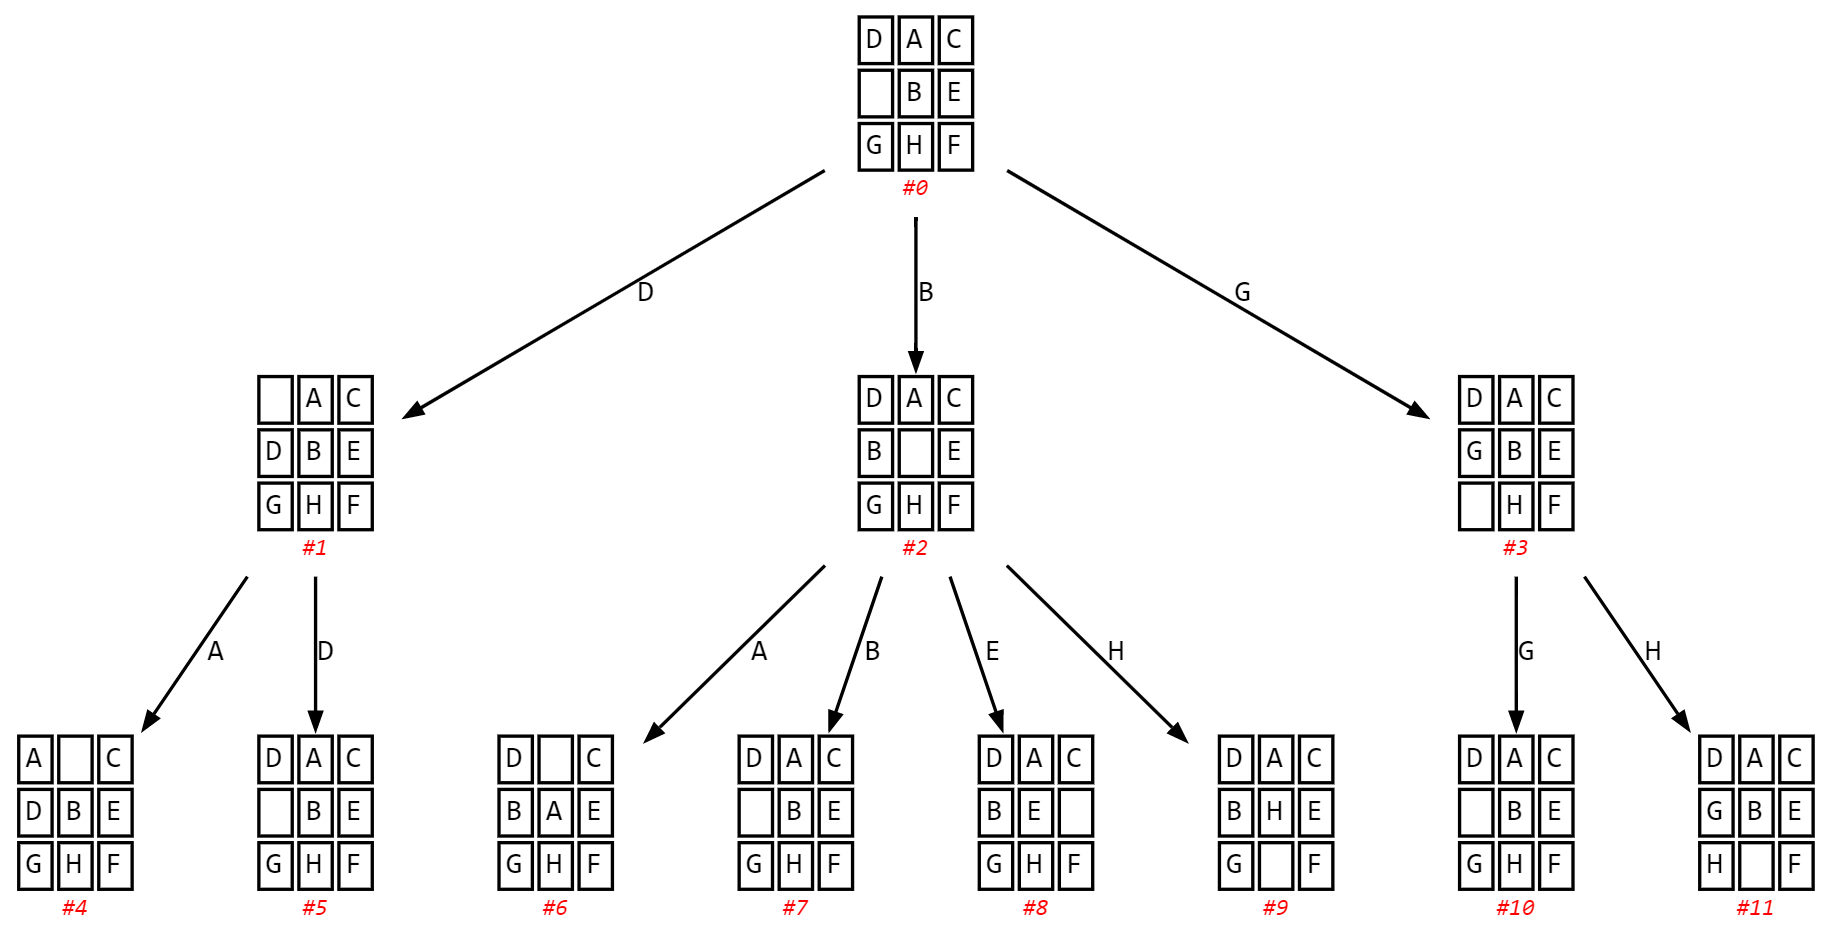

Bevor wir den Algorithmus programmieren, noch ein paar Begriffe:

* Alle Zustandsknoten, die von einem bestimmten Knoten *k* aus durch eine Aktion erreichbar sind, nennen wir die **Nachfolger** oder **Folgeknoten** von *k*
* Wenn wir die Nachfolger eines Knotens *k* bestimmen und in den Baum einfügen, sprechen wir davon, dass wir *k* **expandieren**
* Die Menge derjenigen Knoten, die schon im Baum sind, aber noch nicht expandiert wurden (d.h. ihre Nachfolgeknoten wurden noch nicht ermittelt und eingefügt), bezeichnen wir als **Grenze** (engl.: *fringe*, *frontier* oder auch *open list*)


Nun können wir die __Breitensuche__ definieren. Intuitiv macht der folgende Algorithmus nichts anderes als so lange Knoten zu expandieren und zur "Grenze" hinzuzufügen, bis der Zielzustand gefunden wurde:

In [6]:
def breitensuche(problem):
    """durchsucht den Baum, so dass Knoten mit niedriger Suchtiefe zuerst untersucht werden"""
    grenze = [Knoten(problem.startzustand)]  # Warteschlange mit dem Startknoten initialisieren

    while grenze:  # Solange noch Knoten in der Warteschlange sind...
        aktuell = grenze.pop(0)  # Hole den vordersten Knoten aus der Grenze
        if problem.ist_zielzustand(aktuell.zustand):    # Bin ich am Ziel?
            return aktuell.pfad_hierher()
        folge_knoten = aktuell.expandiere(problem)
        grenze.extend(folge_knoten)   # Folgezustände ans Ende der Schlange einfügen
    return None  # keine Lösung gefunden

Und diese wenigen Zeilen sollen schon reichen, um das Schiebpuzzle zu lösen?

Probieren wir es doch einfach aus:

In [7]:
start = 'DAC BEGHF'
ziel = 'ABCDEFGH '
problem = Schiebepuzzle(start, ziel)
loesung = breitensuche(problem)
print(loesung)

[0, 1, 4, 5, 8]


## Wie schnell ist die Breitensuche?
Wir messen die Zeit zur Lösung einiger Schiebepuzzle-Probleme:

In [8]:
leicht = "BC AEFDGH"
mittel = "ACFEBH DG"
schwer = "ABCF DGHE"

ziel  = 'ABCDEFGH '


Die folgende Funktion werden wir immer wieder verwenden, um verschiedenen Suchverfahren zu testen und zu vergleichen.

Beachte, das unsere Funktion `breitensuche` hier als **Argument** der Funktion `teste_algorithmus` übergeben und später aufgerufen wird. `teste_algorithmus` ist also eine **Funktion höherer Ordnung** (higher-order funktion, HOF), die es uns erlaubt, eine Vielzahl anderer Funktionen zu testen.

In [9]:
def teste_algorithmus(start, algorithmus, Problemklasse=Schiebepuzzle, zielzustand=ziel):
    problem = Problemklasse(start, ziel)
    loesung = algorithmus(problem)   # !!! hier wird die als Argument übergebene Funktion aufgerufen
    print(f"Die Lösung besteht aus {len(loesung)} Zügen: {loesung}")
    return loesung

loesung = teste_algorithmus(leicht, breitensuche)

Die Lösung besteht aus 6 Zügen: [1, 0, 3, 6, 7, 8]


##### Laufzeit messen mit `%%time`
Wir nutzen in diesem und späteren Jupyter-Notebooks den Befehl `%%time`, eines von vielen [*magic commands*](https://towardsdatascience.com/6-magic-commands-that-every-data-wizard-should-know-87eaf9e2567c), um die Laufzeit eines Suchalgorithmus zu messen.  Das Tolle daran ist, dass wir unseren eigentlichen Code nicht verändern müssen, sondern ihm einfach `%%time` voranstellen:

In [10]:
%%time
loesung = teste_algorithmus(leicht, breitensuche)

Die Lösung besteht aus 6 Zügen: [1, 0, 3, 6, 7, 8]
Wall time: 2.99 ms


In [11]:
%%time
loesung = teste_algorithmus(mittel, breitensuche)

Die Lösung besteht aus 10 Zügen: [7, 8, 5, 2, 1, 4, 3, 6, 7, 8]
Wall time: 4.29 s


In [12]:
# Bitte diese Zelle nur ausführen (Kommentarzeichen entfernen), wenn du dir gerade 
# sowieso einen frischen Kaffee machen wolltest ;-)

# %%time
# loesung = teste_algorithmus(schwer, breitensuche)

Die Laufzeiten für die beiden Tests variieren von Rechner zu Rechner. Offensichtlich ist jedoch:

- Das Problem `einfach` wird in wenigen _Millisekunden_ gelöst. Die Lösung ist 6 Züge lang.
- Für `mittel` mit einer Lösungslänge von 10 werden bereits einige _Sekunden_ benötigt.
- die Lösung von `schwer` ist nur 12 Züge lang - und die Breitensuche benötigt dafür fast 10 Minuten!!! Auf einem schnelleren Rechner mögen es u.U. nur 5 Minuten sein, aber das ändert nichts daran, dass das Problem offensichtlich um *Größenordnungen* schwerer ist als eines dessen Lösung nur 2 Züge kürzer ist.

Vergleicht man Lösungslänge und Suchzeit von `einfach` und `schwer`, sieht man:
Für eine ungefähr *doppelt* so lange Lösungssequenz benötigt das Programm die *hunderttausendfache* Zeit!!!

Wenn man bedenkt, dass statt einigen Hundert nun über _hunderttausend_ Zustände untersucht werden, ist das eigentlich auch nicht verwunderlich!

Das Problem in der folgenden Zelle ist dasjenige aus dem "interaktiven Spiel" im vorigen Notebook. Es kann von einem Menschen mit etwas Erfahrung in maximal 16 Zügen und in einigen Minuten gelöst werden. 

Eine Lösungslänge von 16 Zügen bedeutet aber, dass unsere Version der Breitensuche bei einem geschätzten Verzweigungsfaktor von 3 ca. $3^{16} = 43046721$, d.h. über _43 Millionen_ Zugfolgen untersucht. Und das dauert... 

In [13]:
# Auf keinen Fall ausführen! You have been warned!

## %%time
## loesung = teste_algorithmus('CBD AFGEH', breitensuche)   # Bitte nicht starten!!!

## Breitensuche mit Duplikatseliminierung


Schau dir im Abschnitt "Breitensuche" den abgebildeten Suchbaum noch einmal genauer an. Was fällt dir auf... insb. wenn du die Knoten #0 und #5 miteinander vergleichst? Was passiert vermutlich, sobald Knoten #5 expandiert wird?

Genau - unsere Breitensuche erkennt nicht, wenn sie *mehrmals* auf denselben Knoten stößt. Unter Umständen wird dieser wieder und wieder expandiert... und seine Folgeknoten damit auch immer wieder! 

Z.B. führen die beiden folgenden Zugsequenzen aus dem Startzustand in denselben Ergebniszustand:

In [14]:
from schiebepuzzle import zugsequenz_ausfuehren, pprint
start_zustand = 'DAC BEGHF'
ende1 = zugsequenz_ausfuehren(start_zustand, [4])
ende2 = zugsequenz_ausfuehren(start_zustand, [6, 7, 4, 7, 6, 3, 4])
pprint(ende1, ueberschrift="Ende 1")
print()
pprint(ende2, ueberschrift="Ende 2")
ende1 == ende2

Ende 1
D A C
B   E
G H F

Ende 2
D A C
B   E
G H F


True

Es ist klar, dass die zweite Zugsequenz `[6, 7, 4, 7, 6, 3, 4]` für die Suche uninteressant ist - denn wir können denselben Zustand ja viel schneller durch `[4]` erreichen.

Konsequenz: Wir prüfen ab jetzt jedesmal, wenn wir einen Zug machen, ob wir den resultierenden Zustand schon kennen. Ist das der Fall, dann haben wir ihn auf einem kürzeren (oder maximal gleich langen) Weg schon einmal erreicht und müssen ihn nicht noch einmal expandieren.

Die Änderungen im Algorithmus sind nur klein: Wir merken uns alle Zustände, die wir untersucht haben, in der sogenannten _Closed List_ (die in Wirklichkeit eine _Menge_ ist). Treffen wir ein zweites Mal auf denselben Zustand (das erkennen wir daran, dass er bereits in der _closed list_ ist), ignorieren wir ihn.

In [15]:
def breitensuche_graph(problem):
    """durchsucht den Baum, so dass Knoten mit niedriger Suchtiefe zuerst untersucht werden"""
    untersucht = set()  # Zustände, die wir schon einmal besucht haben. Zu Anfang: leere Menge.
    grenze = [Knoten(problem.startzustand)]

    while grenze:
        knoten = grenze.pop(0)
        untersucht.add(knoten.zustand)   # Knoten wird nicht noch einmal untersucht werden
        if problem.ist_zielzustand(knoten.zustand):
            return knoten.pfad_hierher()
        folge_knoten = knoten.expandiere(problem)
        neue_knoten = [k for k in folge_knoten        # NEU: betrachte nur unbekannte Knoten
                       if k.zustand not in untersucht and k.zustand not in grenze]
        grenze.extend(neue_knoten)
    return None

Mal sehen, ob wir bei unserem mittelschweren Beispielproblem immer noch die Lösung in 10 Zügen finden:

In [16]:
%%time
loesung = teste_algorithmus(mittel, breitensuche_graph)

Die Lösung besteht aus 10 Zügen: [7, 8, 5, 2, 1, 4, 3, 6, 7, 8]
Wall time: 19.7 ms


Das sieht gut aus, sogar deutlich schneller. Vielleicht können wir es nun sogar wagen, das _schwere_ Problem mit der Breitensuche zu lösen:

In [17]:
%%time
loesung = teste_algorithmus(schwer, breitensuche_graph)

Die Lösung besteht aus 12 Zügen: [3, 6, 7, 4, 5, 8, 7, 6, 3, 4, 5, 8]
Wall time: 83 ms


Wow... das ging ja schnell. So schwer war das Problem offensichtlich doch nicht  ;-)

Offensichtlich haben wir durch die winzige Änderung mit der *closed list* enorm viele Zustandsuntersuchungen eingespart. Denn man kann abschätzen:

In [18]:
knoten = 3**12

def lesbar(zahl):
    bezeichungen = ["Tausend", "Millionen", "Milliarden", "Billionen", "Billiarden"]
    bezeichnung = ""
    while zahl > 1000:
        zahl = zahl / 1000
        bezeichnung = bezeichungen.pop(0)
    return f"{zahl:.1f} {bezeichnung}" if bezeichnung else str(zahl)

print(f"Die naive Breitensuche-Implementierung hätte bei diesem Problem ca. {lesbar(knoten)} Knoten untersucht!")

Die naive Breitensuche-Implementierung hätte bei diesem Problem ca. 531.4 Tausend Knoten untersucht!


Schauen wir uns einmal an, wie die Lösung ausgeführt wird:

In [19]:
zugsequenz_ausfuehren(schwer, loesung, anzeigen=True)

A B C
F   D
G H E

Zug 1: Verschiebe F von Position 3 nach 4:
A B C
  F D
G H E

Zug 2: Verschiebe G von Position 6 nach 3:
A B C
G F D
  H E

Zug 3: Verschiebe H von Position 7 nach 6:
A B C
G F D
H   E

Zug 4: Verschiebe F von Position 4 nach 7:
A B C
G   D
H F E

Zug 5: Verschiebe D von Position 5 nach 4:
A B C
G D  
H F E

Zug 6: Verschiebe E von Position 8 nach 5:
A B C
G D E
H F  

Zug 7: Verschiebe F von Position 7 nach 8:
A B C
G D E
H   F

Zug 8: Verschiebe H von Position 6 nach 7:
A B C
G D E
  H F

Zug 9: Verschiebe G von Position 3 nach 6:
A B C
  D E
G H F

Zug 10: Verschiebe D von Position 4 nach 3:
A B C
D   E
G H F

Zug 11: Verschiebe E von Position 5 nach 4:
A B C
D E  
G H F

Zug 12: Verschiebe F von Position 8 nach 5:
A B C
D E F
G H  


'ABCDEFGH '

Aber natürlich gibt es selbst für die verbesserte Breitensuche noch "harte" Probleme:

In [20]:
%%time
hart = 'CBHEADFG '
# loesung = teste_algorithmus(hart, breitensuche_graph)    # Bitte nur vor einer Kaffeepause starten!

Wall time: 0 ns


Hier die Ausgabe auf einem Testrechner:

`Die Lösung besteht aus 26 Zügen: [7, 4, 1, 0, 3, 4, 5, 2, 1, 0, 3, 4, 7, 6, 3, 4, 7, 8, 5, 4, 1, 0, 3, 6, 7, 8]  
Wall time: 8min 19s`

Hier benötigt selbst unser verbesserter Algorithmus eine unakzeptabel lange Zeit. Es gibt einfach zu viele Zugsequenzen, die untersucht werden müssen. Und das immer noch die einfachste Puzzle-Variante auf einem 3x3-Feld. Für größere Spielfelder müssen wir uns etwas "Intelligenteres" einfallen lassen!!!

Trotzdem, wir dürfen durchaus schon zufrieden sein, denn...

In [21]:
print(f"Die naive Breitensuche-Implementierung hätte bei diesem Problem ca. {lesbar(3**26)} Knoten untersucht!!!")

Die naive Breitensuche-Implementierung hätte bei diesem Problem ca. 2.5 Billionen Knoten untersucht!!!
